# Labeled VAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [ ]:
SAVE_NAME = 'vae.conv.labels'

In [ ]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32


In [3]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [4]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../../cpunks-10k/cpunks/data/punks.json


In [ ]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [6]:
input_dim = 222
hidden_dims = (64, 32)
latent_dim = 20
classes_dim = len(dataset._label_keys)  # 92

model = M.vae.LabeledVAE(input_dim, hidden_dims, latent_dim, classes_dim)
criterion = M.vae.Loss()


train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)


INFO | model: pallets.models.vae.LabeledVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 511340.343750
INFO | epoch 1 ( 35%) loss: 36567.423161
INFO | epoch 1 ( 70%) loss: 20193.799364
INFO | epoch 1 (100%) loss: 15286.630175
INFO | epoch 1 (test) loss: 3011.733999
INFO | epoch 2 (  0%) loss: 3168.992188
INFO | epoch 2 ( 35%) loss: 2989.891227
INFO | epoch 2 ( 70%) loss: 2919.502352
INFO | epoch 2 (100%) loss: 2848.778398
INFO | epoch 2 (test) loss: 2585.529720
INFO | epoch 3 (  0%) loss: 2605.232666
INFO | epoch 3 ( 35%) loss: 2550.318004
INFO | epoch 3 ( 70%) loss: 2491.184335
INFO | epoch 3 (100%) loss: 2441.376340
INFO | epoch 3 (test) loss: 2258.153040
INFO | epoch 4 (  0%) loss: 2315.772461
INFO | epoch 4 ( 35%) loss: 2248.870850
INFO | epoch 4 ( 70%) loss: 2213.483287
INFO | epoch 4 (100%) loss: 2185.638485
INFO | epoch 4 (test) loss: 2073.863382
INFO | epoch 5 (  0%) loss: 2103.203613
INFO | epoch 5 ( 35%) loss

# Results

torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


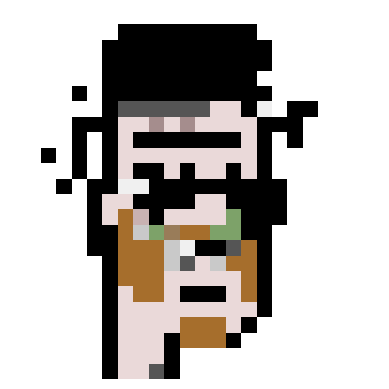

In [9]:

z = torch.randn(1, latent_dim + classes_dim).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


In [31]:
import random

label_idx = int(random.random() * len(dataset))
_, features = dataset[label_idx]

enabled_features = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['male', 'muttonchops', 'mohawkDark']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


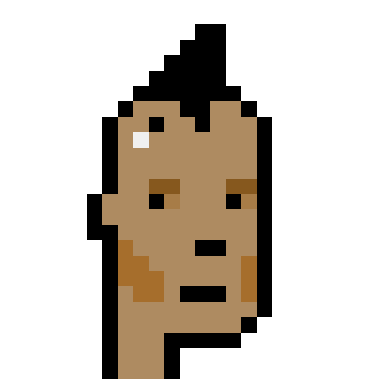

In [32]:
# Generate new image

z = torch.randn(1, latent_dim).to(device)
z = torch.concat([z, features.unsqueeze(0)], dim=1)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


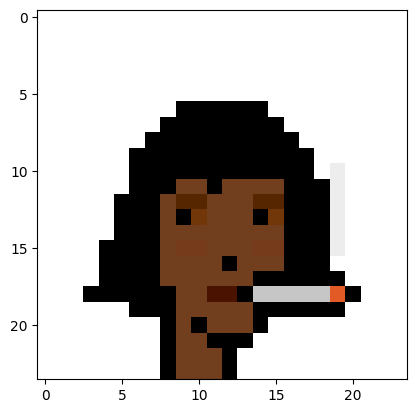

In [14]:
punk = I.get_punk_tensor(1000)

plt.imshow(transforms.functional.to_pil_image(punk))
plt.show()



In [15]:
import json
ps_labels = json.load(open("../../cpunks-10k/cpunks/data/punks.json"))
punk_labels = torch.tensor([v for _,v in ps_labels["1000"].items()])
punk_labels = punk_labels.unsqueeze(0)
punk_labels = punk_labels.to(device)


torch.Size([1, 222, 24, 24])


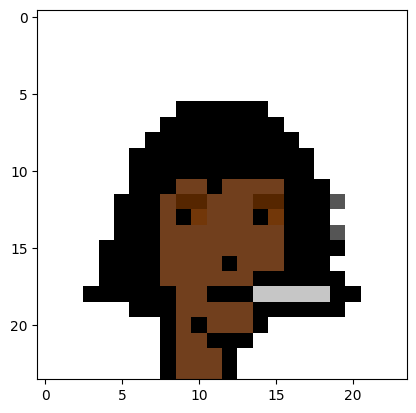

In [16]:
punk = I.get_punk_tensor(1000)

p = DS.rgba_to_one_hot(punk, mapper)
p = p.unsqueeze(0)
p = p.to(device)

model.eval()
with torch.no_grad():
    reconstructed, mu, logcar = model.forward(p, punk_labels)
    print(reconstructed.shape)

recon_punk = reconstructed[0].cpu()
recon_punk = DS.one_hot_to_rgba(recon_punk, mapper)
plt.imshow(transforms.functional.to_pil_image(recon_punk.cpu()))
plt.show()


## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

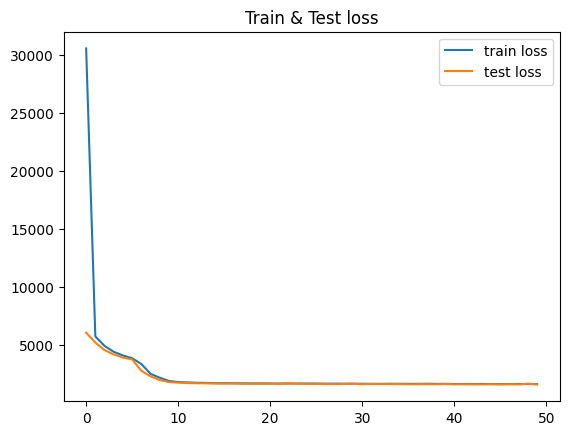

In [17]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [12]:
train_losses


[30573.260350004155,
 5697.556796459441,
 4882.752680352393,
 4371.2769701802135,
 4057.198269674964,
 3817.647393625679,
 3317.664884959552,
 2469.5850553039118,
 2135.465425640133,
 1850.9470607676406,
 1759.9394449004044,
 1725.0646092840966,
 1697.4676818847656,
 1687.3448147604652,
 1663.6082692247755,
 1662.413048602165,
 1656.1682109426945,
 1649.3506967531027,
 1644.6739481391637,
 1644.4879110349832,
 1635.2827425476507,
 1634.4507044798938,
 1638.5145845886664,
 1631.61127856099,
 1632.0217974507216,
 1632.0558463022219,
 1619.982811244667,
 1624.3537363904588,
 1616.1746239628353,
 1616.4182771723322,
 1609.5188225279462,
 1608.0298785486966,
 1606.6645706393194,
 1613.5932991623033,
 1609.2080250192196,
 1604.6667576783093,
 1605.770013254585,
 1610.5000641734887,
 1604.7654754422235,
 1602.8270726846465,
 1594.682070035461,
 1592.6850839168467,
 1592.2811364789382,
 1595.269455064273,
 1590.7247967009848,
 1585.4571862186947,
 1588.0010041581822,
 1592.098573617056,
 1588.

In [13]:
test_losses


[6023.467998504639,
 5171.059440612793,
 4516.306079864502,
 4147.726764678955,
 3870.5424613952637,
 3715.3104858398438,
 2731.510732650757,
 2253.013219833374,
 1930.4830951690674,
 1759.9115056991577,
 1708.724820137024,
 1674.341097831726,
 1657.233413696289,
 1645.8657703399658,
 1636.0715827941895,
 1625.0347919464111,
 1636.626202583313,
 1612.6365537643433,
 1606.5855598449707,
 1613.7549238204956,
 1619.0354499816895,
 1598.3876395225525,
 1647.698369026184,
 1611.4299325942993,
 1598.373285293579,
 1596.9993705749512,
 1584.324709892273,
 1579.7937316894531,
 1595.193788766861,
 1611.8467111587524,
 1574.4376726150513,
 1591.8318309783936,
 1582.6719856262207,
 1584.0058727264404,
 1577.8293905258179,
 1564.4385213851929,
 1569.4074001312256,
 1577.948546409607,
 1568.1067972183228,
 1586.6217470169067,
 1558.4797716140747,
 1564.3857345581055,
 1559.6508197784424,
 1555.0657424926758,
 1567.6000633239746,
 1551.4973034858704,
 1565.4451160430908,
 1552.98659324646,
 1615.442